In [1]:
import os

# os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import quad_tri3, shape_fn_tri3
from femsolver.operator import FemOperator
import jax.numpy as jnp
#import sparsediffax as sd
import sparsejac
import numpy as np



import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

from petsc4py import PETSc

In [2]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

We define a function to compute the linear elastic energy density based on the
displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


In [3]:
# --- Material model (linear elasticity: plane strain) ---
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


def compute_stress(eps, mu=1.0, lmbda=1.0):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


def linear_elasticity_energy(grad_u, mu=1.0, lmbda=1.0):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)

The femsolver provides a generic class `FemOperator` that can be used to solve
FEM problems. This operator is the core of the library as it provide functions
that can automatically integrate the energy density function defined above over
the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for
  the elements
- `compute_shape_fn`: a function that returns the shape functions for the
  elements
- `compute_energy`: a function that returns the energy density for the elements


In [27]:
fem = FemOperator(quad_tri3, shape_fn_tri3, linear_elasticity_energy)

Now we prepare the mesh and the boundary conditions and solve the linear
elasticity problem.


In [28]:
# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes
u = jnp.zeros(n_dofs)


# --- Total energy ---
def total_energy(u_flat, coords, elements, fem):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    return jnp.sum(fem.integrate(u_cell, x_cell))


# creating functions to compute the gradient of total energy using jax
grad_E = jax.grad(total_energy)


In [29]:
# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)

prescribed_dofs = jnp.concatenate(
    [
        2 * right_nodes,
    ]
)
prescibed_disp = 0.3

prescribed_values = jnp.zeros(n_dofs).at[prescribed_dofs].set(prescibed_disp)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

In [30]:
def create_sparse_structure(elements, nstate, K_shape):
    # elements: (num_elements, nodes_per_element)
    elements = jnp.array(elements)
    num_elements, nodes_per_element = elements.shape

    # Compute all (i, j, k, l) combinations for each element
    i_idx = jnp.repeat(
        elements, nodes_per_element, axis=1
    )  # (num_elements, nodes_per_element^2)
    j_idx = jnp.tile(
        elements, (1, nodes_per_element)
    )  # (num_elements, nodes_per_element^2)

    # Expand for nstate
    k_idx = jnp.arange(nstate, dtype=jnp.int32)
    l_idx = jnp.arange(nstate, dtype=jnp.int32)
    k_idx, l_idx = jnp.meshgrid(k_idx, l_idx, indexing="ij")
    k_idx = k_idx.flatten()
    l_idx = l_idx.flatten()

    # For each element, get all (row, col) indices
    def element_indices(i, j):
        row = nstate * i + k_idx
        col = nstate * j + l_idx
        return row, col

    # Vectorize over all (i, j) pairs for all elements
    row_idx, col_idx = jax.vmap(element_indices)(i_idx.flatten(), j_idx.flatten())

    # Flatten and clip to matrix size
    row_idx = row_idx.flatten()
    col_idx = col_idx.flatten()
    mask = (row_idx < K_shape[0]) & (col_idx < K_shape[1])
    row_idx = row_idx[mask]
    col_idx = col_idx[mask]

    # Create the sparse structure
    indices = np.unique(np.vstack((row_idx, col_idx)).T, axis=0)
    return np.ones(indices.shape[0], dtype=jnp.int32), indices.astype(np.int32)

In [31]:
data, indices = create_sparse_structure(elements, n_dofs_per_node, (n_dofs, n_dofs))

In [32]:
sparsity_pattern = jax.experimental.sparse.BCOO((data, indices), shape=(n_dofs, n_dofs))

In [33]:
#grad_E_partial = partial(grad_E, coords=coords, elements=elements, fem=fem)

In [34]:
#hess_E_sparse = sd.jacfwd_sparse(grad_E_partial, sparsity_pattern)

In [35]:
#%%timeit
#K_sparse =  hess_E_sparse(u).block_until_ready()

In [36]:
hess_E_sparse = sparsejac.jacfwd(grad_E, sparsity=sparsity_pattern)

In [37]:
K_sparse = hess_E_sparse(u, coords, elements, fem)

In [38]:
K_bc_data = K_sparse.data.copy()

In [39]:
for dof in fixed_dofs:
    indexes = np.where(indices[:, 0] == dof)[0]
    for idx in indexes:
        K_bc_data = K_bc_data.at[idx].set(0)


    idx = np.where(np.all(indices == np.array([dof, dof]), axis=1))[0]
    K_bc_data = K_bc_data.at[idx].set(1)

for dof in prescribed_dofs:
    indexes = np.where(indices[:, 0] == dof)[0]
    for idx in indexes:
        K_bc_data = K_bc_data.at[idx].set(0)


    idx = np.where(np.all(indices == np.array([dof, dof]), axis=1))[0]
    K_bc_data = K_bc_data.at[idx].set(1)

In [40]:
#K_bc = jax.experimental.sparse.BCOO(
#    (K_bc_data, indices), shape=(n_dofs, n_dofs)
#)

We will use PETSc to solve the sparse linear system.


In [41]:
A = PETSc.Mat()
A.createAIJ(size=(n_dofs, n_dofs))

In [42]:
for index, value in zip(indices, K_bc_data):
    row, col = index
    A.setValue(row, col, value)

In [43]:
A.assemble()

In [44]:
ksp = PETSc.KSP().create()
ksp.setOperators(A)

In [45]:
b = A.createVecLeft()
b.setArray(prescribed_values)

In [46]:
x = A.createVecRight()

ksp = PETSc.KSP().create()
ksp.setOperators(A)

ksp.setConvergenceHistory()
ksp.getPC().setType('none')
ksp.solve(b, x)

In [47]:
u_full = x.array

Now we prepare some functions to compute the stress and to plot the deformed
shape with the von-mises stress.


In [48]:
# --- Compute von Mises stress ---
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


# --- Compute von Mises stress per element ---
def compute_element_stress(coords, u, elements, fem):
    u_cells = u.reshape(-1, n_dofs_per_node)[elements]
    coords_cells = coords[elements]

    def element_von_mises(u_e, x_e):
        qp, _ = quad_tri3()
        xi = qp[0]  # just take one point per element
        grad_u = fem.gradient(xi, u_e, x_e)
        eps = compute_strain(grad_u)
        sigma = compute_stress(eps)
        return von_mises_stress(sigma)

    return jax.vmap(element_von_mises)(u_cells, coords_cells)


# --- Visualization ---
from femsolver.plotting import STYLE_PATH


def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    plt.figure(figsize=(5, 4))
    plt.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(label="Von Mises Stress")
    plt.title("Von Mises Stress on Deformed Mesh")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

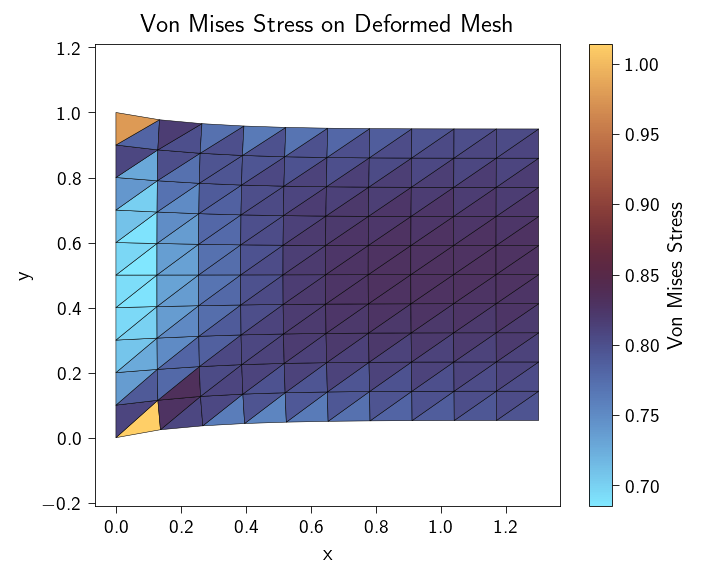

In [49]:
# --- Compute the stress ---
u = u_full.reshape(-1, n_dofs_per_node)

stress_vm = compute_element_stress(coords, u, elements, fem)

# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm)